# Run ssd model under onnxruntime 
comment

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
from object_detection.utils import label_map_util
import matplotlib.pyplot as plt
import glob
import time
import json

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image, ImageDraw, ImageColor

import onnxruntime as rt

In [2]:
# change working directory
ROOT = os.path.dirname(os.getcwd())

model = "pre_trained_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.onnx"
## create label index
label_file = "Label_map/mscoco_complete_label_map.pbtxt"
image_dir = "images/test2017"

# load GPU into environnement
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['ROOT'] = ROOT

label_file = os.path.join(ROOT,label_file)
category_index = label_map_util.create_category_index_from_labelmap(label_file,use_display_name=True)
model = os.path.join(ROOT,model)

In [3]:
def preprocess_and_one_images(path_to_file, image_size=[640,640]):
    if os.path.exists(path_to_file) and os.path.isfile(path_to_file):
        img = Image.open(path_to_file)     
        # preprocess
        #np_image = np.array(img.getdata()).reshape(image_size[0],image_size[0],3)
        np_image = img.resize((image_size[0],image_size[1]))
        np_image = np.array(np_image)
        np_image = np.expand_dims(np_image.astype(np.uint8), axis=0)
        return (img, np_image)
    else:
        print("error")
        sys.stderr.write("The file doesn't exist")

(1, 640, 640, 3)


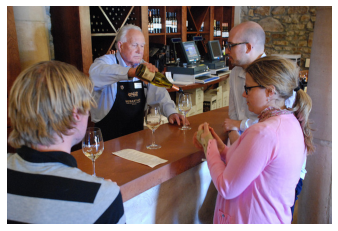

In [4]:
image_path = os.path.join(ROOT,image_dir, '000000000069.jpg')
image,np_image = preprocess_and_one_images(image_path)

print(np_image.shape)
# plot original image
plt.axis('off')
plt.imshow(image)
plt.show()

In [5]:
sess = rt.InferenceSession(model)

#outputs = ['detection_anchor_indices', 'detection_boxes', 'detection_classes','detection_multiclass_scores','detection_scores','num_detections','raw_detection_boxes','raw_detection_scores']

results = sess.run(None,{'input_tensor:0':np_image})

In [6]:
detection_anchor_indices, detection_boxes, detection_classes,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores = results

In [7]:
def draw_detection(draw,d,c,sc,t=0.6):
    if sc >= t:
        """Draw box and label for 1 detection."""
        width, height = draw.im.size
        # the box is relative to the image size so we multiply with height and width to get pixels.
        top = d[0] * height
        left = d[1] * width
        bottom = d[2] * height
        right = d[3] * width
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
        right = min(width, np.floor(right + 0.5).astype('int32'))
        
        label = category_index[c]['name']
        label = label + ' '+ format(sc * 100, '.2f') +'%'
        label_size = draw.textsize(label)
        if top - label_size[1] >= 0:
            text_origin = tuple(np.array([left, top - label_size[1]]))
        else:
            text_origin = tuple(np.array([left, top + 1]))
        color = ImageColor.getrgb("red")
        thickness = 0
        draw.rectangle([left + thickness, top + thickness, right - thickness, bottom - thickness], outline=color)
        draw.text(text_origin, label, fill=color)  # , font=font)
    
    

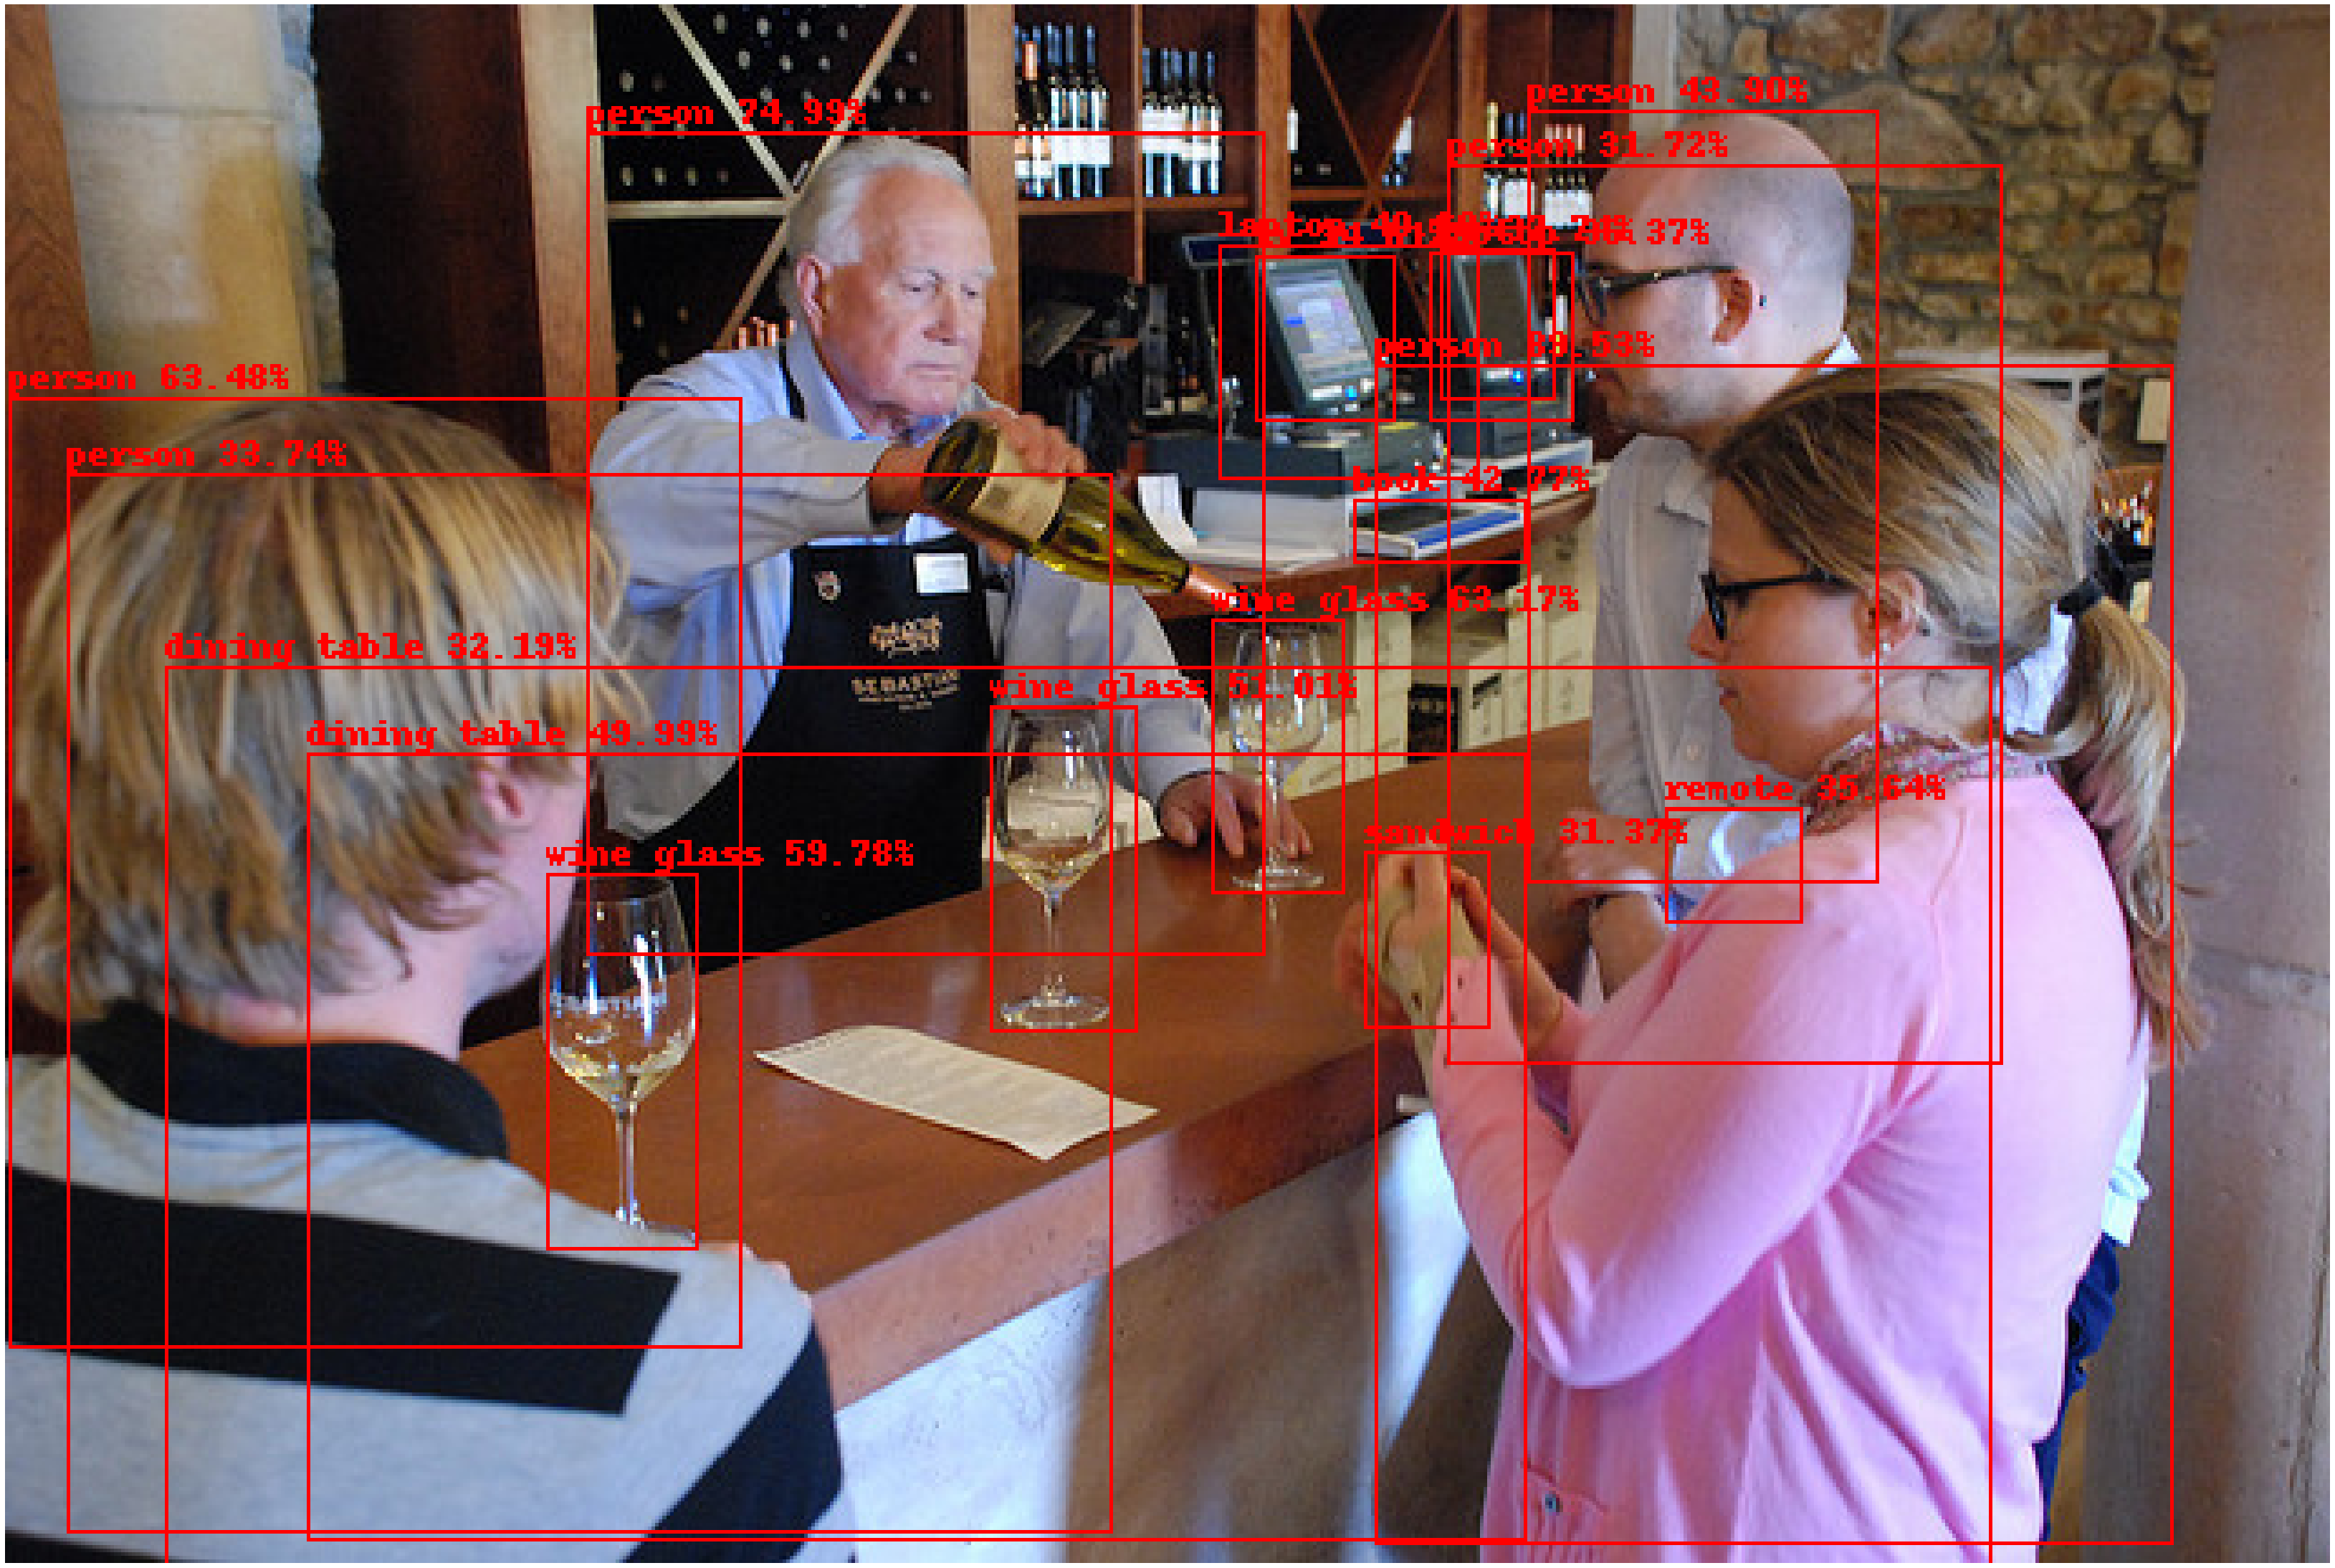

In [8]:
batch_size = num_detections.shape[0]
draw = ImageDraw.Draw(image)
for batch in range(0, batch_size):
    for detection in range(0, int(num_detections[batch])):
        c = detection_classes[batch][detection]
        d = detection_boxes[batch][detection]
        sc = detection_scores[batch][detection]
        draw_detection(draw, d, c,sc, t=0.3)
plt.figure(figsize=(80, 40))
plt.axis('off')
plt.imshow(image)
plt.show()

## Evaluation process FPS and mAP

In [9]:
image_dir = "images/val2017"
image_dir = os.path.join(ROOT,image_dir)

ann = "annotations/instances_val2017.json"
ann = os.path.join(ROOT,ann)

results_json = 'SSD_rcnn_test.json'
results_json = os.path.join(os.path.abspath(os.getcwd()),results_json)

In [10]:
def preprocess_and_load_batch_images(path_to_dir, batch_size=32, image_size=[640,640]):
    image_list = []
    count = 0
    if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
        for filename in glob.glob(path_to_dir + '/*.jpg'):
            _,np_image = preprocess_and_one_images(filename,image_size)
            
            image_list.append({'id':int(filename.split('.')[0].split('/')[-1]),
                               'np_img':np_image})
            count = count + 1
            if count == batch_size:
                count = 0
                yield image_list

In [11]:
def get_detection(num_detections,detection_boxes,detection_classes,detection_scores):
    batch_size = num_detections.shape[0]
    for batch in range(0, batch_size):
        for detection in range(0, int(num_detections[batch])):
            c = detection_classes[batch][detection]
            b = detection_boxes[batch][detection]
            sc = detection_scores[batch][detection]
            yield (b,c,sc)

In [12]:
def scalar_image(images_size,bbox):
    pass

In [14]:
N_warmup_run=50
batch_size=32
size=[640,640]

total_batch_time = []
total_image = 0
results =[]

# delete results json file if exist
if os.path.exists(results_json):
    os.remove(results_json)

for batch in preprocess_and_load_batch_images(image_dir, batch_size=batch_size, image_size=size):
    total_image = total_image + len(batch)
    for img in batch:
        start_time = time.time()
        ## apply model
        detections = sess.run(None,{'input_tensor:0':np_image})
        end_time = time.time()
        total_batch_time = np.append(total_batch_time, end_time-start_time)
        detection_anchor_indices, detection_boxes, detection_classes,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores = detections
        
        for elt in range(0, num_detections.shape[0]):
            for boxes,classes,score in get_detection(num_detections,detection_boxes,detection_classes,detection_scores):
                x = float(boxes[0])
                y = float(boxes[1])
                w = float(boxes[2]- boxes[0] + 1)
                h = float(boxes[3]- boxes[1] + 1)
                results.append({'image_id':img['id'],'category_id': int(classes),'bbox':[x, y, w, h],'score': float(score)})
        print(f"FPS pro Batch {(total_batch_time[-len(batch):]).mean()} ms")
    
json.dump(results,open(results_json,'w'), indent = 4)
print(f"FPS {total_image/(total_batch_time[-len(batch):]).sum()} ms")

cocoGt = COCO(ann)

cocoDt = cocoGt.loadRes(results_json)

imgIds = sorted(cocoGt.getImgIds())

cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')

cocoEval.params.imgIds = imgIds

cocoEval.evaluate()
cocoEval.accumulate()

print(cocoEval.summarize())


FPS pro Batch 4.198221445083618 ms
FPS pro Batch 4.162790417671204 ms
FPS pro Batch 4.130008300145467 ms
FPS pro Batch 4.1144644021987915 ms


KeyboardInterrupt: 